In [1]:
import torch
import yaml
import os
from models.rbm import RBM
from models.crbm import CRBM
from utils.data_loader import load_image_data, load_tabular_data
from train import train_rbm
from generate import generate_samples
from utils.augmentation import augment_dataset
from utils.evaluation import evaluate_classifier, ks_test_distribution
from utils.visualization import visualize_tsne
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
with open('configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
if config["dataset_type"] == "image":
    train_loader, train_data = load_image_data(config["batch_size"])
    n_visible = 28 * 28
    dataset_features = train_data.data.view(-1, 28*28).float() / 255.0
    dataset_labels = train_data.targets
elif config["dataset_type"] == "tabular":
    csv_path = config["dataset_name"]
    train_loader, features, labels = load_tabular_data(csv_path, config["batch_size"])
    n_visible = features.shape[1]
    dataset_features = torch.tensor(features).float()
    dataset_labels = torch.tensor(labels).long()
else:
    raise ValueError("Invalid dataset_type in config (must be 'image' or 'tabular')")

In [5]:
if config["rbm_type"] == "RBM":
    model = RBM(n_visible=n_visible, n_hidden=config["hidden_units"]).to(device)
    conditional = False
else:
    n_cond = len(torch.unique(dataset_labels))
    model = CRBM(n_visible=n_visible, n_hidden=config["hidden_units"], n_cond=n_cond).to(device)
    conditional = True

# Training
train_rbm(model, train_loader, epochs=config["epochs"], lr=config["learning_rate"], 
          adaptive_cd=config["adaptive_cd"], crbm=conditional)

Epoch 1/30 | Loss: 0.48100
Epoch 2/30 | Loss: 0.48106
Epoch 3/30 | Loss: 0.48115
Epoch 4/30 | Loss: 0.48105
Epoch 5/30 | Loss: 0.48124
Epoch 6/30 | Loss: 0.48106
Epoch 7/30 | Loss: 0.48104
Epoch 8/30 | Loss: 0.48115
Epoch 9/30 | Loss: 0.48115
Epoch 10/30 | Loss: 0.48111
Epoch 11/30 | Loss: 0.48171
Epoch 12/30 | Loss: 0.48176
Epoch 13/30 | Loss: 0.48176
Epoch 14/30 | Loss: 0.48183
Epoch 15/30 | Loss: 0.48175
Epoch 16/30 | Loss: 0.48157
Epoch 17/30 | Loss: 0.48177
Epoch 18/30 | Loss: 0.48170
Epoch 19/30 | Loss: 0.48166
Epoch 20/30 | Loss: 0.48182
Epoch 21/30 | Loss: 0.48166
Epoch 22/30 | Loss: 0.48176
Epoch 23/30 | Loss: 0.48175
Epoch 24/30 | Loss: 0.48178
Epoch 25/30 | Loss: 0.48173
Epoch 26/30 | Loss: 0.48175
Epoch 27/30 | Loss: 0.48175
Epoch 28/30 | Loss: 0.48168
Epoch 29/30 | Loss: 0.48190
Epoch 30/30 | Loss: 0.48165


In [6]:
print("Generating synthetic data...")
if conditional:
    # Prepare class-conditional vectors
    cond_vectors = torch.eye(len(torch.unique(dataset_labels))).to(device)
    cond_vectors_repeated = cond_vectors.repeat_interleave(config["augmentation_size"] // cond_vectors.shape[0], dim=0)
    synthetic_data = generate_samples(model, config["augmentation_size"], n_visible, device, conditional_vectors=cond_vectors_repeated)
    synth_labels = torch.arange(len(cond_vectors)).repeat_interleave(config["augmentation_size"] // cond_vectors.shape[0])
else:
    synthetic_data = generate_samples(model, config["augmentation_size"], n_visible, device)
    synth_labels = torch.randint(0, len(torch.unique(dataset_labels)), (config["augmentation_size"],))

Generating synthetic data...


In [7]:
real_X = dataset_features.numpy()
real_y = dataset_labels.numpy()
synth_X = synthetic_data.view(synthetic_data.shape[0], -1).numpy()
synth_y = synth_labels.numpy()


Visualizing real vs synthetic samples...


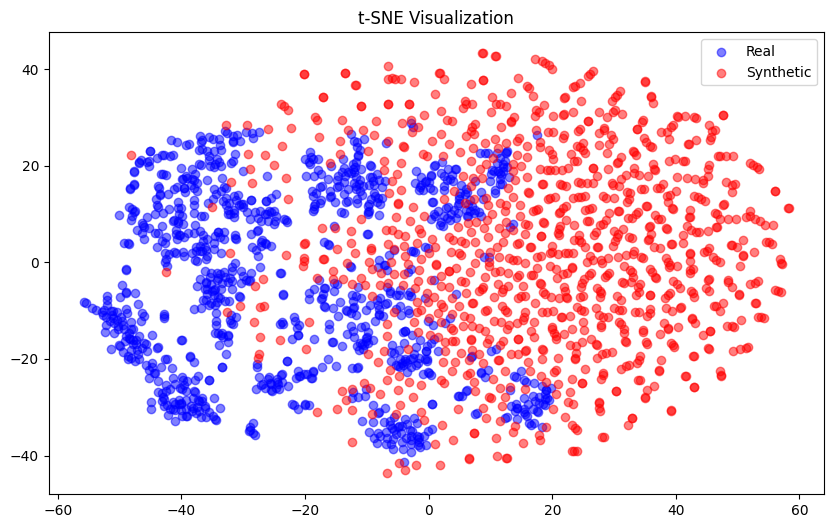

In [8]:
if config["visualize"]:
    print("Visualizing real vs synthetic samples...")
    visualize_tsne(dataset_features[:1000], synthetic_data[:1000])

# Augment and evaluate
aug_X, aug_y = augment_dataset(torch.tensor(real_X), torch.tensor(synth_X), 
                               torch.tensor(real_y), torch.tensor(synth_y))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(real_X, real_y, test_size=0.2, random_state=42)
X_train_aug, y_train_aug = aug_X.numpy(), aug_y.numpy()

# Evaluate classifiers
print("Evaluating classifier on real data only...")
acc_real = evaluate_classifier(X_train, y_train, X_test, y_test)
print(f"Accuracy (original data): {acc_real:.4f}")

print("Evaluating classifier on augmented data...")
acc_aug = evaluate_classifier(X_train_aug, y_train_aug, X_test, y_test)
print(f"Accuracy (augmented data): {acc_aug:.4f}")

# Statistical tests for distribution similarity
print("Performing KS-Tests between real and synthetic feature distributions...")
ks_results = ks_test_distribution(real_X, synth_X)
for i, stat, pval in ks_results:
    print(f"Feature {i}: KS-stat={stat:.4f}, p-value={pval:.4f}")

Evaluating classifier on real data only...
Accuracy (original data): 0.9217
Evaluating classifier on augmented data...
Accuracy (augmented data): 0.9389
Performing KS-Tests between real and synthetic feature distributions...
Feature 0: KS-stat=0.5070, p-value=0.0000
Feature 1: KS-stat=0.5040, p-value=0.0000
Feature 2: KS-stat=0.5310, p-value=0.0000
Feature 3: KS-stat=0.5660, p-value=0.0000
Feature 4: KS-stat=0.5070, p-value=0.0000
Feature 5: KS-stat=0.4840, p-value=0.0000
Feature 6: KS-stat=0.5080, p-value=0.0000
Feature 7: KS-stat=0.5140, p-value=0.0000
Feature 8: KS-stat=0.5100, p-value=0.0000
Feature 9: KS-stat=0.5030, p-value=0.0000
Feature 10: KS-stat=0.5220, p-value=0.0000
Feature 11: KS-stat=0.4880, p-value=0.0000
Feature 12: KS-stat=0.4960, p-value=0.0000
Feature 13: KS-stat=0.4820, p-value=0.0000
Feature 14: KS-stat=0.5220, p-value=0.0000
Feature 15: KS-stat=0.4650, p-value=0.0000
Feature 16: KS-stat=0.4690, p-value=0.0000
Feature 17: KS-stat=0.5130, p-value=0.0000
Feature 18: